# Task 01: Prediction for time of using SCC - Regression

METADATA - SUPERCOMP INFORMATION
--------------------------------

Id - index
UID - user id                                                               [unused]  
GID - group id                                                              [unused]  
Area - subject area (defined by group)                                      [categorical -> OK]   
JobName - task name specified by the user                                   [categorical -> OK]  
Partition - the cluster on which the task was launched                      [categorical -> OK]  
ReqNodes - requested number of nodes                                        [numerical]  
ReqCPUS - requested number of processors                                    [numerical]  
Timelimit - user estimate of task completion time                           [encoding time -> OK]  
Submit - date when the task was uploaded to the system                      [encoding date -> OK]  
Start - the date when the task was launched for execution by the scheduler  [encoding date -> OK]  
Priority - task priority                                                    [numerical -> OK]  
Elapsed - actual task execution time (target variable Y)                    [encoding time -> OK]  
State - information about how the task completed (successfully, was canceled, etc.)   [categorical -> OK]  
ExitCode - code generated after some scc task                               [categorical -> OK]  

In [1]:
!nvidia-smi

Tue Mar 19 14:42:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1F:00.0 Off |                    0 |
| N/A   35C    P0    41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:20:00.0 Off |                    0 |
| N/A   

### Step 1: Preprocessing

In [2]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [3]:
# load dataset
dataset = pd.read_csv("datasets/scc_data.csv")

In [4]:
data = dataset
data.head()

,Id,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode
0,0,1420,88068,astrophys,Smilei0,tornado,70,1960,10-00:00:00,2021-08-11T16:53:04,2021-09-17T09:46:21,1-11:27:29,1,CANCELLED by 50260,0:0
1,1,52951,3414,phys,v149_td,tornado,2,56,14-00:00:00,2021-08-18T10:38:10,2021-08-18T10:46:12,14-00:00:38,1,TIMEOUT,0:0
2,2,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:50:05,2021-08-18T14:50:05,13-21:05:40,1,CANCELLED by 50341,0:0
3,3,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:52:31,2021-08-18T14:52:32,13-21:04:39,1,CANCELLED by 50341,0:0
4,4,70802,33028,energ,dcss.slurm,tornado-k40,1,1,14-00:00:00,2021-08-19T15:33:49,2021-08-19T15:33:50,14-00:00:04,1,TIMEOUT,0:0


In [5]:
print("#users = ", len(dataset["UID"].unique()))

#users =  245


In [6]:
print("#total of samples = ", len(data))

#total of samples =  1290729


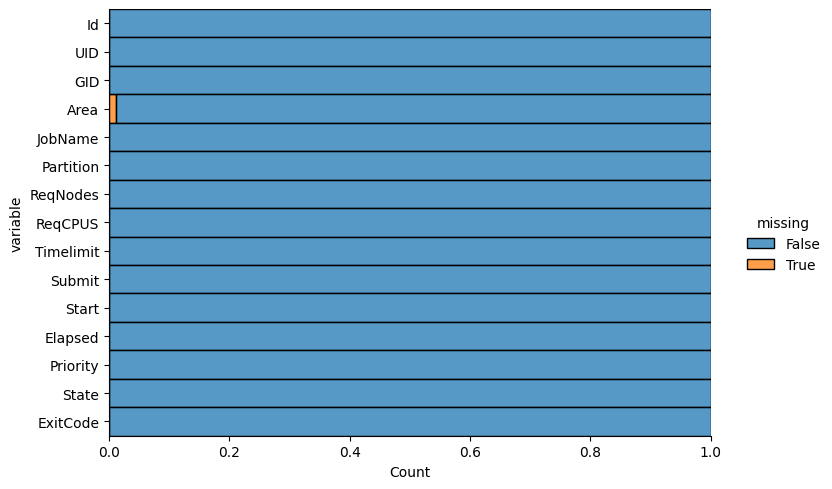

In [7]:
# check missing data
sns.displot(
    data = data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5
)

plt.show()

In [8]:
# drop rows with null values
data = data.dropna().reset_index(drop = True)
print("#total samples without missing values = ", len(data))

#total samples without missing values =  1275902


In [9]:
# check information of dataset
print("Number of samples: ", len(data.index))
print("Columns = ", data.columns)
print("#Columns = ", len(data.columns))

Number of samples:  1275902
Columns =  Index(['Id', 'UID', 'GID', 'Area', 'JobName', 'Partition', 'ReqNodes',
       'ReqCPUS', 'Timelimit', 'Submit', 'Start', 'Elapsed', 'Priority',
       'State', 'ExitCode'],
      dtype='object')
#Columns =  15


Dates encoding

In [10]:
import calendar

def encoding_date(data, name_col):
    #categorical variants of values
    year_names = list(np.arange(2020, 2025, 1))
    year_variants = [f"{name_col}Year{i}" for i in year_names]
    month_names = list(calendar.month_name)
    month_variants = [f"{name_col}Month{j}" for j in month_names if j!='']
    dayw_names = list(calendar.day_name)
    dayw_variants = [f"{name_col}DayofWeek{k}" for k in dayw_names]
    # temporal dataframe
    tmp_cols = year_variants + month_variants + dayw_variants
    tmp_frame = pd.DataFrame(np.zeros((len(data), len(tmp_cols))), columns = tmp_cols)
    # generate datetime
    dates_mod = pd.to_datetime(data[name_col])
    
    for i in range(len(data)):        
        tmp_frame.loc[i, f"{name_col}Year{dates_mod[i].year}"] = 1
        tmp_frame.loc[i, f"{name_col}Month{calendar.month_name[dates_mod[i].month]}"] = 1
        tmp_frame.loc[i, f"{name_col}DayofWeek{calendar.day_name[dates_mod[i].day_of_week]}"] = 1

    # concatenate data-frames
    data = pd.concat([data, tmp_frame], axis = 1, ignore_index = False)

    return data

Encoding states

In [11]:
def replace_cancelled_states(status):
    if "CANCELLED" in status:
        return "CANCELLED"
    return status

In [12]:
def encoding_states(data, column):
    data[column] = data[column].apply(lambda x: replace_cancelled_states(x))
    return data

In [13]:
data = encoding_states(data, "State")

Transcurring time encoding  
Format: D-HH:MM:SS

In [14]:
# function to convert transcurred time to seconds
def time_conversion(time_data):
    # extract time units
    if "-" in time_data:
        days, timer = time_data.split("-")
    else:
        days = 0
        timer = time_data 
    
    days = int(days)
    hours, min, sec = map(int, timer.split(":"))

    # calculate total seconds
    total_sec = days*24*60*60 + hours*60*60 + min*60 + sec
    
    return total_sec

In [15]:
# function to encode transcurred time for entire column
def encoding_time(data, name_col):
    data[name_col+"Tsec"] = data[name_col].apply(time_conversion)

    return data

Encode time difference between Task submitted and started

In [16]:
# function to calculate difference between 2 dates
from datetime import datetime

def difference_dates(date1, date2):
    dformat = "%Y-%m-%dT%H:%M:%S"
    date1 = datetime.strptime(date1, dformat)
    date2 = datetime.strptime(date2, dformat)
    tdiff = date2 - date2

    return tdiff.total_seconds()

In [17]:
# function to calculate wait time between submission and start task
def encode_twatting(data, col1, col2):
    data["WaittingTsec"] = data.apply(lambda row: difference_dates(row[col1], row[col2]), axis = 1)

    return data

One-hot encoding for categorical variables

In [18]:
# check number of different instances per each categorical variable
print("#Area = ", data["Area"].nunique())
print("#JobName = ", data["JobName"].nunique())  # not relevant
print("#Partition = ", data["Partition"].nunique())
print("#State = ", data["State"].nunique())
print("#Exit-code = ", data["ExitCode"].nunique())  # not relevant

#Area =  10
#JobName =  801125
#Partition =  5
#State =  6
#Exit-code =  84


In [19]:
# extract levels of categories
dict_categories = {
    "Area": data["Area"].unique().tolist(),
    "Partition": data["Partition"].unique().tolist(),
    "State": data["State"].unique().tolist()
}

In [20]:
# store dictionary of categories
import json

def save_dictionary(dict, file_path):
    with open(file_path, "w") as file:
        json.dump(dict, file)

In [21]:
save_dictionary(dict_categories, "datasets/db_features.json")

In [22]:
# load dictionary
def load_dictionary(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

In [23]:
# load dictionary
db_categories = load_dictionary("datasets/db_features.json")

In [24]:
list(db_categories.keys())

['Area', 'Partition', 'State']

In [25]:
# one-hot encoder for categorical variables 
def encoding_category(data, category):
    col_instances = [f"{category}{i}" for i in db_categories[category]]
    tmp_df = pd.DataFrame(np.zeros((len(data), len(col_instances))), columns = col_instances)
    for i in range(len(data)):        
        tmp_df.loc[i, f"{category}{data[category][i]}"] = 1
    # concatenate data-frames
    data = pd.concat([data, tmp_df], axis = 1, ignore_index = False)

    return data

Final pipeline for data preprocessing

In [26]:
# master function pipeline for preprocessing input data
def preprocessing_pipeline(data, db_categories):        
    # drop Id, UID, GID
    data = data.drop(columns = ["Id", "UID", "GID", "JobName", "ExitCode"])
    # encode the Submit dates
    data = encoding_date(data, "Submit")
    # encode the Start dates
    data = encoding_date(data, "Start")
    # encode states
    data = encoding_states(data, "State")
    # encode the Time limit
    data = encoding_time(data, "Timelimit")
    # encode the Time elapsed
    data = encoding_time(data, "Elapsed")
    # encode the Time of waitting
    data = encode_twatting(data, "Submit", "Start")
    # drop some preprocessed columns
    data = data.drop(columns = ["Submit", "Start", "Timelimit", "Elapsed"])
    
    # one-hot encoding for categorical variables
    list_cats = list(db_categories.keys())

    for category in list_cats:
        data = encoding_category(data, category)    
    # drop the original preprocessed columns
    data = data.drop(columns = list_cats)    

    return data

In [27]:
import time
start_tpreproc = time.time()

In [28]:
# preprocess entire data
data = preprocessing_pipeline(data, db_categories)
data.tail()

,ReqNodes,ReqCPUS,Priority,SubmitYear2020,SubmitYear2021,SubmitYear2022,SubmitYear2023,SubmitYear2024,SubmitMonthJanuary,SubmitMonthFebruary,...,Partitiontornado-k40,Partitiong2,Partitioncascade,Partitionnv,StateCANCELLED,StateTIMEOUT,StateCOMPLETED,StateFAILED,StateNODE_FAIL,StateOUT_OF_MEMORY
1275897,1,28,480,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1275898,1,28,480,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1275899,1,28,480,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1275900,1,1,233,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1275901,1,1,233,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
end_tpreproc = time.time()
print(f"Preprocessing time: {end_tpreproc - start_tpreproc} seconds")

Preprocessing time: 1860.072135925293 seconds


In [30]:
print("Data dimensions: ", data.shape)

Data dimensions:  (1275902, 75)


In [31]:
# check columns metadata 
data.columns

Index(['ReqNodes', 'ReqCPUS', 'Priority', 'SubmitYear2020', 'SubmitYear2021',
       'SubmitYear2022', 'SubmitYear2023', 'SubmitYear2024',
       'SubmitMonthJanuary', 'SubmitMonthFebruary', 'SubmitMonthMarch',
       'SubmitMonthApril', 'SubmitMonthMay', 'SubmitMonthJune',
       'SubmitMonthJuly', 'SubmitMonthAugust', 'SubmitMonthSeptember',
       'SubmitMonthOctober', 'SubmitMonthNovember', 'SubmitMonthDecember',
       'SubmitDayofWeekMonday', 'SubmitDayofWeekTuesday',
       'SubmitDayofWeekWednesday', 'SubmitDayofWeekThursday',
       'SubmitDayofWeekFriday', 'SubmitDayofWeekSaturday',
       'SubmitDayofWeekSunday', 'StartYear2020', 'StartYear2021',
       'StartYear2022', 'StartYear2023', 'StartYear2024', 'StartMonthJanuary',
       'StartMonthFebruary', 'StartMonthMarch', 'StartMonthApril',
       'StartMonthMay', 'StartMonthJune', 'StartMonthJuly', 'StartMonthAugust',
       'StartMonthSeptember', 'StartMonthOctober', 'StartMonthNovember',
       'StartMonthDecember', 'Start

### Step 2: Statistical Analysis

Numerical Features -> Timelimit_tsec and Elapsed_tsec

In [215]:
import seaborn as sns

In [216]:
def plot_time_distribution(data, feature_name):    
    sns.histplot(data[feature_name], color = "gray")
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Frequencies")
    plt.title("Histogram distribution for " + feature_name)    
    plt.show()

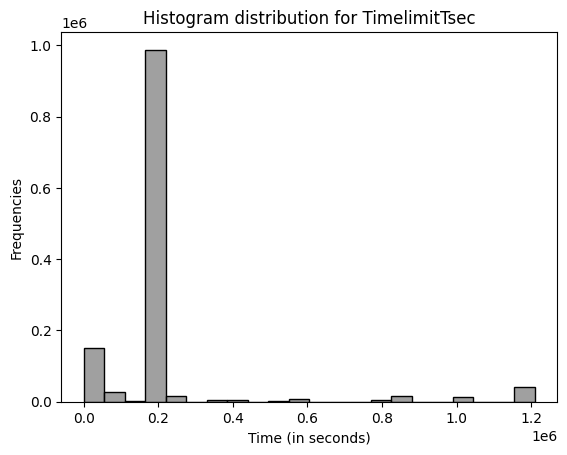

In [218]:
plot_time_distribution(data, "TimelimitTsec")

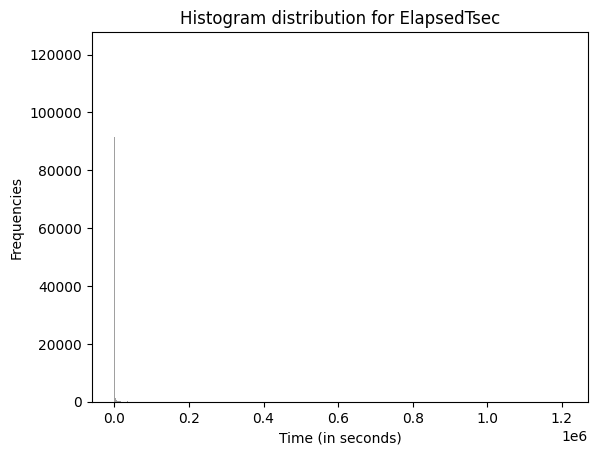

In [219]:
plot_time_distribution(data, "ElapsedTsec")

In [220]:
def plot_time_boxplot(data):
    fig, axs = plt.subplots(1, 2, figsize = (10, 6))
    sns.boxplot(data["TimelimitTsec"], ax = axs[0])
    axs[0].set_title("Box Plot for Time Limit")
    sns.boxplot(data["ElapsedTsec"], ax = axs[1])
    axs[1].set_title("Box plot for Time Elapsed")
    plt.tight_layout()
    plt.show()

In [221]:
# information about quartiles
data[["TimelimitTsec", "ElapsedTsec"]].describe()

,TimelimitTsec,ElapsedTsec
count,1.275902e+06,1.275902e+06
mean,2.137279e+05,8.527928e+03
std,2.297573e+05,5.210806e+04
min,6.000000e+01,1.000000e+00
25%,1.728000e+05,1.180000e+02
50%,1.728000e+05,4.130000e+02
75%,1.728000e+05,2.008000e+03
max,1.209600e+06,1.209638e+06


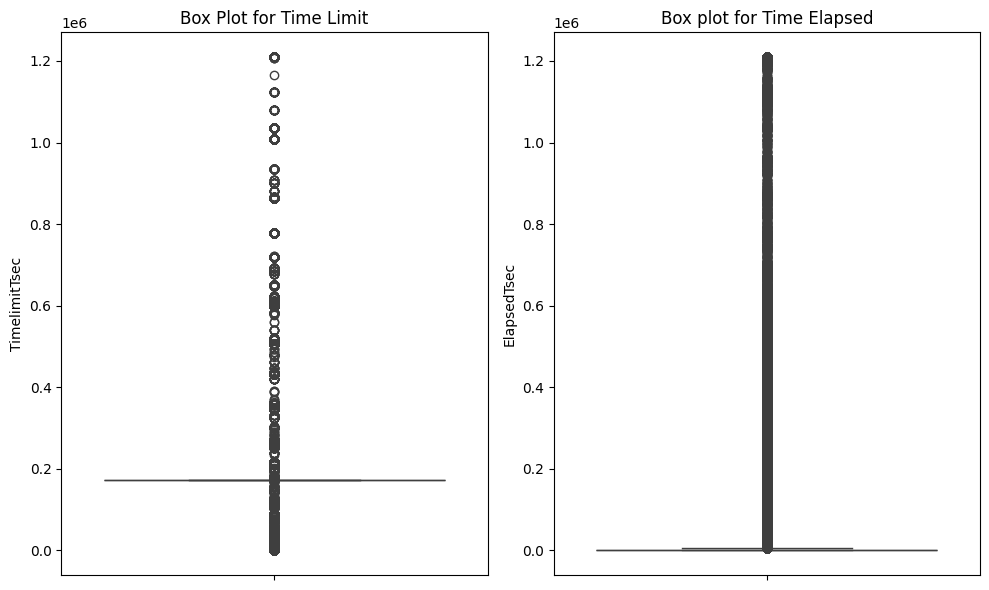

In [222]:
plot_time_boxplot(data)

In [223]:
def count_categories(data, feature_name):
    categ_instances = [categ for categ in data.columns if categ.startswith(feature_name)]
    categ_counts = data[categ_instances].sum()

    return categ_counts

In [224]:
def plot_count_categories(feature_name, results):
    sns.barplot(x = results.values.tolist(), y = results.index.tolist(), orient = "y")
    plt.title("Statistical analysis by " + feature_name)
    plt.show()

Categorical Features -> Area

In [225]:
count_areas = count_categories(data, "Area")
print(count_areas)

Areaastrophys      2338.0
Areaphys          54034.0
Areamech          10800.0
Areaenerg          8985.0
Areamach          34500.0
Arearadiophys     81953.0
Areabiophys       21923.0
Areageophys      999420.0
Areabioinf        41840.0
Areait            20109.0
dtype: float64


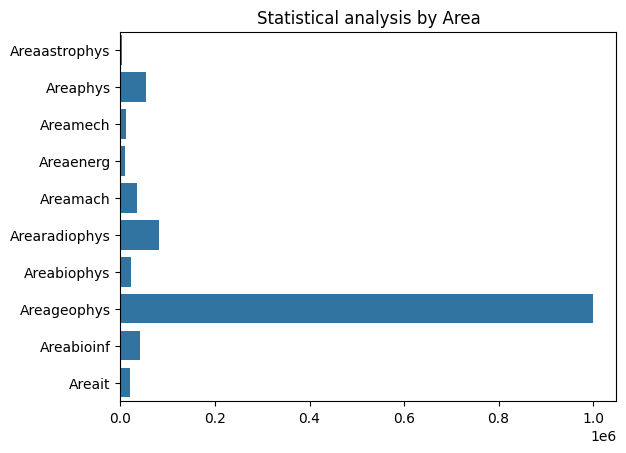

In [226]:
plot_count_categories("Area", count_areas)

Outliers detection using Z-score method

In [32]:
from scipy import stats

def outliers_detection(data, feature):
    z_score = stats.zscore(data[feature])
    z_threshold = 3
    outliers = data[z_score.abs() > z_threshold]
    
    return outliers

In [33]:
lst_outliers = outliers_detection(data, "ElapsedTsec")

In [37]:
lst_outliers.sort_values(by = "ElapsedTsec")

,ReqNodes,ReqCPUS,Priority,SubmitYear2020,SubmitYear2021,SubmitYear2022,SubmitYear2023,SubmitYear2024,SubmitMonthJanuary,SubmitMonthFebruary,...,Partitiontornado-k40,Partitiong2,Partitioncascade,Partitionnv,StateCANCELLED,StateTIMEOUT,StateCOMPLETED,StateFAILED,StateNODE_FAIL,StateOUT_OF_MEMORY
1145682,2,48,194,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1232288,1,16,2670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1232290,1,16,2670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1232294,1,16,2670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1232289,1,16,2670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241301,2,112,371,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
349450,1,1,539,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
546899,7,196,43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
160131,1,1,438,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
print(f"#samples outlier to distribution = {len(lst_outliers)}")
print(f"%outliers = {round(100* len(lst_outliers)/len(data), 2)} %")

#samples outlier to distribution = 12963
%outliers = 1.02 %


Split data

In [39]:
# split independent (X) and dependent variable (Y)
x = data.drop(columns = ["ElapsedTsec"])
y = data["ElapsedTsec"]

In [40]:
# split train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [41]:
# check number of samples
print("#train samples = ", len(x_train))
print("#test samples = ", len(x_test))

#train samples =  1020721
#test samples =  255181


Functions to save and load models

In [42]:
import pickle

# function to save model
def save_model(filename, model):
    with open(filename, "wb") as file:
        pickle.dump(model, file)

In [43]:
# function to load model
def load_model(filename):
    with open(filename, "rb") as file:
        return pickle.load(file)

### Training models  
Benchmark for models:  
- XGBoost Regressor  
- LightGBM
- AdaBoost

#### XGBoost Regressor

Training with XGBoost Regressor + Hyperparameter Tuning

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
import xgboost as xgb

xgb_params = {          
    "max_depth": [16, 32, 48, 64],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.8, 0.9],     
    "tree_method": ["hist"],
    "objective": ["reg:squarederror"]
}

In [46]:
# function for training
def XGBModel(x_train, y_train, params):
    # define the model    
    model = xgb.XGBRegressor()
    
    # hyperparameter optimization
    grid_search = GridSearchCV(estimator = model,
                               param_grid = params,
                               scoring = "neg_mean_squared_error",
                               cv = 10,
                               n_jobs = -1
                            )
    grid_search.fit(x_train, y_train)
    
    # get best model
    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    
    return best_model

In [47]:
start_ttrain = time.time()

In [48]:
xgb_model = XGBModel(x_train, y_train, xgb_params)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 16, 'objective': 'reg:squarederror', 'subsample': 0.7, 'tree_method': 'hist'}


In [49]:
end_ttrain = time.time()
print(f"Time of training: {end_ttrain - start_ttrain} seconds")

Time of training: 3283.6048588752747 seconds


In [50]:
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
# save xgb model
save_model("models/xgb_scc_perform_v10.pkl", xgb_model)

Inference with XGBoost Regressor

In [52]:
# recover the model
rec_xgb = load_model("models/xgb_scc_perform_v10.pkl")

In [53]:
# function to evaluate
from sklearn.metrics import mean_squared_error, r2_score

def eval_model_perform(model, x, y):    
    y_pred = model.predict(x)
    rmse_val = np.sqrt(mean_squared_error(y, y_pred))
    r2_val = r2_score(y, y_pred)

    return rmse_val, r2_val

In [54]:
# metrics for train set
rmse_xgb_train, r2_xgb_train = eval_model_perform(rec_xgb, x_train, y_train)
print(f"R-MSE train score: {rmse_xgb_train:.3f}")
print(f"R^2 train score: {r2_xgb_train:.3f}")

R-MSE train score: 20553.332
R^2 train score: 0.844


In [55]:
# r2-score for test set
rmse_xgb_test, r2_xgb_test = eval_model_perform(rec_xgb, x_test, y_test)
print(f"R-MSE train score: {rmse_xgb_test:.3f}")
print(f"R^2 train score: {r2_xgb_test:.3f}")

R-MSE train score: 25663.483
R^2 train score: 0.758


*******

#### LightGBM Regressor

Training with LightGBM Regressor + Hyperparameter Tuning

In [96]:
!pip show lightgbm

Name: lightgbm
Version: 2.2.3
Summary: LightGBM Python Package
Home-page: https://github.com/Microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (Microsoft)
Location: /home/iknthsait/holtech/.local/lib/python3.10/site-packages
Requires: numpy, scikit-learn, scipy
Required-by: 


In [56]:
# import packages
import lightgbm as lgbm

# define grid hyperparameters
lgbm_params = {    
    "num_leaves": [1024, 2048, 3092, 4096],
    "max_depth": [20, 30, 40, 50],
    "learning_rate": [0.01, 0.05, 0.075, 0.1],
    "subsample": [0.8, 0.9],
    "subsample_freq": [10] # re-sample without replacement every 10 iterations
                         # and extract bagging_fraction% of training data
}

In [57]:
# define the LightGBM regressor
def LightGBModel(x_train, y_train, params):
    lgbm_model = lgbm.LGBMRegressor()
    
    # hyperparameter optimization
    grid_lgbm = GridSearchCV(estimator = lgbm_model,  # regressor model
                         param_grid = params,  # dict of hyperparameters
                         cv = 10,   # 10-fold cross-validation
                         scoring = "r2",
                         verbose = False,
                         n_jobs = -1
                    )
    # fit the model
    grid_lgbm.fit(x_train, y_train)
    
    # take best model
    best_model = grid_lgbm.best_estimator_
    print(grid_lgbm.best_params_)

    return best_model

In [58]:
start_ttrain2 = time.time()

In [59]:
# take the best model
lgbm_model = LightGBModel(x_train, y_train, lgbm_params)

{'learning_rate': 0.1, 'max_depth': 50, 'num_leaves': 2048, 'subsample': 0.9, 'subsample_freq': 10}


In [60]:
end_ttrain2 = time.time()
print(f"Time of training: {end_ttrain2 - start_ttrain2}")

Time of training: 3334.819506883621


In [61]:
lgbm_model

LGBMRegressor(max_depth=50, num_leaves=2048, subsample=0.9, subsample_freq=10)

In [62]:
# save best xgboost model
save_model("models/lgbm_scc_perform_v10.pkl", lgbm_model)

Inference with LightGBM

In [63]:
# recover the model
rec_lgbm = load_model("models/lgbm_scc_perform_v10.pkl")

In [64]:
# metrics for train set
rmse_lgbm_train, r2_lgbm_train = eval_model_perform(rec_lgbm, x_train, y_train)
print(f"R-MSE train score: {rmse_lgbm_train:.3f}")
print(f"R^2 train score: {r2_lgbm_train:.3f}")

R-MSE train score: 21662.738
R^2 train score: 0.827


In [65]:
# metrics for test set
rmse_lgbm_test, r2_lgbm_test = eval_model_perform(rec_lgbm, x_test, y_test)
print(f"R-MSE test score: {rmse_lgbm_test:.3f}")
print(f"R^2 test score: {r2_lgbm_test:.3f}")

R-MSE test score: 25697.623
R^2 test score: 0.757


*******

### Final Results

In [72]:
dict_res = {
    "xgboost": pd.DataFrame({
        "train": {"rmse": rmse_xgb_train, "r2": r2_xgb_train},
        "test": {"rmse": rmse_xgb_test, "r2": r2_xgb_test}        
    }),
    "lgbm": pd.DataFrame({
        "train": {"rmse": rmse_lgbm_train, "r2": r2_lgbm_train},
        "test": {"rmse": rmse_lgbm_test, "r2": r2_lgbm_test}
    })
}

In [73]:
for key, res in dict_res.items():
    print(f"Model: {key}")
    print(res)

Model: xgboost
             train          test
rmse  20553.331621  25663.483203
r2        0.844319      0.758065
Model: lgbm
             train          test
rmse  21662.737583  25697.622861
r2        0.827059      0.757421
